In [1]:
import pandas as pd
import numpy as np

import os
import glob

import re

pd.options.display.max_columns = None

import os
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## **Data Understanding**

Ini adalah dataset publik e-commerce Brasil dari pesanan yang dibuat di Olist Store. Dataset ini memiliki informasi dari 100 ribu pesanan dari tahun 2016 hingga 2018 yang dibuat di beberapa pasar di Brasil. Fitur-fiturnya memungkinkan untuk melihat pesanan dari berbagai dimensi: mulai dari status pesanan, harga, pembayaran, dan kinerja pengiriman hingga lokasi pelanggan, atribut produk, dan akhirnya ulasan yang ditulis oleh pelanggan. Selain itu ada juga dataset geolokasi yang menghubungkan kode pos Brasil dengan koordinat lintang/lintang.

### **Data Schema**

Data dibagi dalam beberapa dataset. Skema data bisa dilihat pada gambar berikut:
<p> <p>
<figure>
  <center><img src = "https://raw.githubusercontent.com/aridiawan/ecommerce-analysis/main/data/raw/ERD.jpg" alt ="Scheme Data Table" width = 900; height = 647></center>
  <figcaption align = "center">Gambar 1. <em>Scheme Data</em> </figcaption>
</figure>
<p> <p>

### **Feature Description**

Berikut adalah fitur-fitur yang tersedia dalam dataset:
<p> <p>
<figure>
  <center><img src = "https://raw.githubusercontent.com/aridiawan/ecommerce-analysis/main/data/raw/Olist-Dataset-Description.jpg" alt ="Scheme Data Table" width = 900; height = 1056></center>
  <figcaption align = "center">Gambar 2. <em>Deskripsi Feature</em> </figcaption>
</figure>
<p> <p>

### **Data Skimming**

In [2]:
# load data
RAW_DATA_DIR = r"..\data\raw"
file_list = glob.glob(RAW_DATA_DIR + "\*.csv")

In [3]:
# function text handling
def efn(text):
    file = text.split('\\')[-1].replace('.csv','')
    return file

def white_string_to_nan(data):
    return data.replace(r'^\s*$', np.nan, regex=True)

In [4]:
# create dictionary of dataset
dfs = {f'{efn(file)}': white_string_to_nan(pd.read_csv(file, engine="pyarrow")) for file in file_list}

In [5]:
# check data info
dataInfo = []

for n in dfs.keys():
    dataInfo.append({
        'dataset_name' : n,
        'shape' : dfs[n].shape,
        'columns' : list(dfs[n].columns),
        'duplicate' : dfs[n].duplicated().sum(),
        'null' : dfs[n].isna().sum().sum(),
        'null_columns' : dfs[n].columns[dfs[n].isna().any()].tolist()
    })

pd.DataFrame(dataInfo)

,dataset_name,shape,columns,duplicate,null,null_columns
0,olist_customers_dataset,"(99441, 5)","[customer_id, customer_unique_id, customer_zip...",0,0,[]
1,olist_geolocation_dataset,"(1000163, 5)","[geolocation_zip_code_prefix, geolocation_lat,...",261831,0,[]
2,olist_orders_dataset,"(99441, 8)","[order_id, customer_id, order_status, order_pu...",0,4908,"[order_approved_at, order_delivered_carrier_da..."
3,olist_order_items_dataset,"(112650, 7)","[order_id, order_item_id, product_id, seller_i...",0,0,[]
4,olist_order_payments_dataset,"(103886, 5)","[order_id, payment_sequential, payment_type, p...",0,0,[]
5,olist_order_reviews_dataset,"(99224, 7)","[review_id, order_id, review_score, review_com...",0,145932,"[review_comment_title, review_comment_message]"
6,olist_products_dataset,"(32951, 9)","[product_id, product_category_name, product_na...",0,2448,"[product_category_name, product_name_lenght, p..."
7,olist_sellers_dataset,"(3095, 4)","[seller_id, seller_zip_code_prefix, seller_cit...",0,0,[]
8,product_category_name_translation,"(71, 2)","[product_category_name, product_category_name_...",0,0,[]


In [6]:
# skimming function
def skim(data, name):
    summary = pd.DataFrame({
                'dataset' : name,
                'column': data.columns.values,
                'type': data.dtypes.values,
                'unique': data.nunique().values,
                'null': data.isna().sum().reset_index()[0],
                'null_pct': round(data.isna().sum().reset_index()[0]/len(data)*100, 2),
                'min': data.dropna().min().values,
                'max': data.dropna().max().values
                })
    return summary

# check
pd.concat([skim(dfs[n], n) for n in dfs.keys()], sort=False, ignore_index=True)

,dataset,column,type,unique,null,null_pct,min,max
0,olist_customers_dataset,customer_id,object,99441,0,0.00,00012a2ce6f8dcda20d059ce98491703,ffffe8b65bbe3087b653a978c870db99
1,olist_customers_dataset,customer_unique_id,object,96096,0,0.00,0000366f3b9a7992bf8c76cfdf3221e2,ffffd2657e2aad2907e67c3e9daecbeb
2,olist_customers_dataset,customer_zip_code_prefix,int64,14994,0,0.00,1003,99990
3,olist_customers_dataset,customer_city,object,4119,0,0.00,abadia dos dourados,zortea
4,olist_customers_dataset,customer_state,object,27,0,0.00,AC,TO
5,olist_geolocation_dataset,geolocation_zip_code_prefix,int64,19015,0,0.00,1001,99990
6,olist_geolocation_dataset,geolocation_lat,float64,717372,0,0.00,-36.605374,45.065933
7,olist_geolocation_dataset,geolocation_lng,float64,717615,0,0.00,-101.466766,121.105394
8,olist_geolocation_dataset,geolocation_city,object,8011,0,0.00,* cidade,óleo
9,olist_geolocation_dataset,geolocation_state,object,27,0,0.00,AC,TO


**Insights**:
* Terdapat duplikasi data (berdasarkan seluruh kolom) di **olist_geolocation_dataset** yang akan diteliti lebih lanjut
* Terdapat missing values di:
    * **olist_orders_dataset** pada kolom: order_approved_at, order_delivered_carrier_date, order_delivered_customer_date
    * **olist_order_reviews** pada kolom: review_message_title, review_message_comment
    * **olist_products_dataset** pada kolom: product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm
<br><br>
* Handling missing values akan dilakukan setelah merging dataset
* Tipe data:
    * IDs (6):
        * customer_unique_id
        * customer_id
        * order_id
        * order_item_id
        * review_id
        * product_id
        * seller_id
<br><br>
    * Categorical (7):
        * order_status, low cardinality (8)
        * product_category_name, high cardinality (72)
        * product_category_name_english, high cardinality (72)
        * customer_zip_code_prefix, high cardinality (14994)
        * customer_city, high cardinality (4119)
        * customer_state, high cardinality (27)
        * payment_type, low cardinality low (5)
<br><br>
    * Datetime (6):
        * order_purchase_timestamp
        * order_approved_at
        * order_delivered_carrier_date
        * order_delivered_customer_date
        * order_estimated_delivery_date
        * shipping_limit_date
<br><br>
    * Numerical, Continuous (3):
        * price
        * freight_value
        * payment_value
<br><br>
    * Numerical, Ordinal (3):
        * review_score
        * payment_sequential, high cardinality (26)
        * payment_installments, high cardinality (24)

#### **olist_customers_dataset**

In [7]:
customers = dfs["olist_customers_dataset"]

In [8]:
customers[customers.duplicated(subset=["customer_unique_id"], keep=False)].sort_values(by=["customer_unique_id"], ignore_index=True).head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
1,1afe8a9c67eec3516c09a8bdcc539090,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
2,1b4a75b3478138e99902678254b260f4,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
3,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
4,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,57055,maceio,AL


#### **olist_geolocation_dataset**

In [9]:
geolocation = dfs["olist_geolocation_dataset"]

In [10]:
geolocation[geolocation.duplicated(keep=False)].sort_values(by=["geolocation_zip_code_prefix", "geolocation_lat"], ignore_index=True).head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1001,-23.551337,-46.634027,sao paulo,SP
1,1001,-23.551337,-46.634027,sao paulo,SP
2,1001,-23.551337,-46.634027,sao paulo,SP
3,1001,-23.550498,-46.634338,sao paulo,SP
4,1001,-23.550498,-46.634338,sao paulo,SP


#### **olist_orders_dataset_df**

In [11]:
orders = dfs["olist_orders_dataset"]

In [12]:
orders[orders.isna().values]["order_status"].value_counts().reset_index()

,order_status,count
0,canceled,1310
1,unavailable,1218
2,shipped,1107
3,invoiced,628
4,processing,602
5,delivered,24
6,created,15
7,approved,4


In [13]:
orders["order_status"].value_counts(normalize=True).reset_index()

,order_status,proportion
0,delivered,0.970203
1,shipped,0.011132
2,canceled,0.006285
3,unavailable,0.006124
4,invoiced,0.003158
5,processing,0.003027
6,created,0.000050
7,approved,0.000020


#### **olist_order_items_dataset**

In [14]:
order_items = dfs["olist_order_items_dataset"]

In [15]:
order_items[order_items.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id", "order_item_id"], ignore_index=True).head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
1,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
2,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
3,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
4,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10


In [16]:
order_items[order_items["freight_value"]==0]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
114,00404fa7a687c8c44ca69d42695aae73,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-15 04:31:26,99.9,0.0
258,00a870c6c06346e85335524935c600c0,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-14 00:14:29,69.9,0.0
483,011c899816ea29773525bd3322dbb6aa,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-07 05:30:45,99.9,0.0
508,012b3f6ab7776a8ab3443a4ad7bef2e6,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
509,012b3f6ab7776a8ab3443a4ad7bef2e6,2,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
...,...,...,...,...,...,...,...
111094,fc698f330ec7fb74859071cc6cb29772,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-04-25 02:31:57,53.9,0.0
111497,fd4907109f6bac23f07064af84bec02d,1,7a10781637204d8d10485c71a6108a2e,4869f7a5dfa277a7dca6462dcf3b52b2,2018-04-30 11:31:32,219.0,0.0
111649,fd95e4b85ebbb81853d4a6be3d61432b,1,53b36df67ebb7c41585e8d54d6772e08,4869f7a5dfa277a7dca6462dcf3b52b2,2018-05-04 11:10:31,106.9,0.0
112182,fee19a0dc7358b6962a611cecf6a37b4,1,f1c7f353075ce59d8a6f3cf58f419c9c,37be5a7c751166fbc5f8ccba4119e043,2017-09-07 22:06:31,195.0,0.0


#### **olist_order_payments_dataset**

In [17]:
order_payments = dfs["olist_order_payments_dataset"]

In [18]:
order_payments[order_payments.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id", "payment_sequential"], ignore_index=True)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
1,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
2,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
3,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
4,0071ee2429bc1efdc43aa3e073a5290e,1,voucher,1,100.00
...,...,...,...,...,...
7402,ffa1dd97810de91a03abd7bd76d2fed1,2,voucher,1,418.73
7403,ffa39020fe7c8a3e907320e1bec4b985,1,credit_card,1,7.13
7404,ffa39020fe7c8a3e907320e1bec4b985,2,voucher,1,64.01
7405,ffc730a0615d28ec19f9cad02cb41442,1,credit_card,1,14.76


In [19]:
order_payments[order_payments["payment_installments"]==0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
79014,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


In [20]:
order_payments[order_payments["payment_value"]==0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.0
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.0
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.0
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.0
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.0


#### **olist_order_reviews_dataset**

In [21]:
order_reviews = dfs["olist_order_reviews_dataset"]

In [22]:
order_reviews[order_reviews.duplicated(subset=["review_id"], keep=False)].sort_values(by=["review_id"])

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
46678,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
29841,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
90677,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,NaN,NaN,2017-09-21,2017-09-26 03:27:47
63193,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,NaN,NaN,2017-09-21,2017-09-26 03:27:47
92876,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,NaN,Produto entregue dentro de embalagem do fornec...,2018-03-07,2018-03-08 03:00:53
...,...,...,...,...,...,...,...
31120,fe5c833752953fed3209646f1f63b53c,4863e15fa53273cc7219c58f5ffda4fb,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ...",2018-02-28,2018-02-28 13:57:52
7870,ff2fc9e68f8aabfbe18d710b83aabd30,2da58e0a7dcfa4ce1e00fad9d03ca3b5,2,NaN,NaN,2018-03-17,2018-03-19 11:44:15
82521,ff2fc9e68f8aabfbe18d710b83aabd30,1078d496cc6ab9a8e6f2be77abf5091b,2,NaN,NaN,2018-03-17,2018-03-19 11:44:15
73951,ffb8cff872a625632ac983eb1f88843c,c44883fc2529b4aa03ca90e7e09d95b6,3,NaN,NaN,2017-07-22,2017-07-26 13:41:07


In [23]:
order_reviews[order_reviews.duplicated(subset=["order_id"], keep=False)].sort_values(by=["order_id"])

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29,2017-08-30 01:59:12
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25,2017-08-29 21:45:57
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22,2018-02-23 12:12:30
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04,2018-03-05 17:02:00
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30,2018-01-02 10:54:06
...,...,...,...,...,...,...,...
27465,5e78482ee783451be6026e5cf0c72de1,ff763b73e473d03c321bcd5a053316e8,3,NaN,Não sei que haverá acontecido os demais chegaram,2017-11-18,2017-11-18 09:02:48
41355,39de8ad3a1a494fc68cc2d5382f052f4,ff850ba359507b996e8b2fbb26df8d03,5,NaN,Envio rapido... Produto 100%,2017-08-16,2017-08-17 11:56:55
18783,80f25f32c00540d49d57796fb6658535,ff850ba359507b996e8b2fbb26df8d03,5,NaN,"Envio rapido, produto conforme descrito no anu...",2017-08-22,2017-08-25 11:40:22
92230,870d856a4873d3a67252b0c51d79b950,ffaabba06c9d293a3c614e0515ddbabc,3,NaN,NaN,2017-12-20,2017-12-20 18:50:16


#### **olist_products_dataset_df**

In [24]:
products = dfs["olist_products_dataset"]

In [25]:
[category for category in products.dropna()["product_category_name"].unique() if '_2' in category]

['eletrodomesticos_2', 'casa_conforto_2']

#### **olist_sellers_dataset_df**

In [26]:
sellers = dfs["olist_sellers_dataset"]

#### **product_category_name_translation_df**

In [27]:
category_translation = dfs["product_category_name_translation"]

In [28]:
[category for category in category_translation.dropna()["product_category_name"].unique() if '_2' in category]

['eletrodomesticos_2', 'casa_conforto_2']

## **Data Cleaning**

#### Replacing order_item_id with order_item_count

In [29]:
order_items["order_item_count"] = [1]*len(order_items)
order_items[order_items["order_item_id"]>4]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_item_count
562,0148d3df00cebda592d4e5f966e300cc,5,ed08ea04c92f5f434c2362f7310fb328,0adac9fbd9a2b63cccaac4f8756c1ca8,2017-08-24 19:24:32,5.53,11.85,1
1136,02a065131a2d2b72b45e2c63135606ad,5,993245facdeea0014e73a3e18750c123,1025f0e2d44d7041d6cf58b6550e0bfa,2018-05-03 03:35:19,125.00,26.95,1
1241,02e0c2efb6d9bb2a95ca90b7e78bec1f,5,f4041d76285c2a34ad5013e8d287a400,1835b56ce799e6a4dc4eddc053f04066,2018-04-05 11:07:40,39.99,12.79,1
1502,03705afa0a4aabe1a734ddb11c1df3f0,5,b40ec43bdfc6d6fdd65e882066a5c895,897060da8b9a21f655304d50fd935913,2017-10-03 08:49:34,177.00,27.78,1
1597,03aba68b07658f28f29612641f08d4ba,5,e7cc48a9daff5436f63d3aad9426f28b,53243585a1d6dc2643021fd1853d8905,2018-08-15 08:50:17,170.00,30.44,1
...,...,...,...,...,...,...,...,...
110677,fb7d6ea70e823cfb1afca3524282cbf9,5,53759a2ecddad2bb87a079a1f1519f73,1f50f920176fa81dab994f9023523100,2018-04-09 05:28:15,53.90,21.35,1
110720,fb8e4428d340ab5bfa482ef6fc97efbc,5,53b36df67ebb7c41585e8d54d6772e08,4869f7a5dfa277a7dca6462dcf3b52b2,2017-09-08 08:44:16,169.90,12.69,1
110895,fbf6a5df377654baa14f40156140e563,5,98a4301b1aacd45984603af55b7a1de4,1900267e848ceeba8fa32d80c1a5f5a8,2018-03-20 02:55:26,53.00,13.73,1
111254,fcbe557f2bb4cd2409d67dec35a1e6f3,5,0a9c1531aa7c17c8c64157b634fa9ba9,86ccac0b835037332a596a33b6949ee1,2017-08-25 14:30:24,29.99,15.10,1


In [30]:
new_order_items = order_items.groupby(["order_id", "product_id", "seller_id", "shipping_limit_date", "price", "freight_value"], as_index=False)["order_item_count"].agg("sum")
new_order_items[new_order_items.duplicated(subset=["order_id"], keep=False)].tail(10)

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_item_count
102316,ffb8f7de8940249a3221252818937ecb,803f77475e1b51b47f1bfec4f2ec353f,c9c7905cffc4ef9ff9f113554423e671,2018-07-25 09:04:32,79.99,6.37,1
102317,ffb8f7de8940249a3221252818937ecb,bd0ac51dc93e62c4dbe6ca9d70a9b311,1d4587203296c8f4ad134dc286fa6db0,2018-07-27 09:04:32,64.50,42.47,1
102318,ffb8f7de8940249a3221252818937ecb,bd6e8cf9fe4122c385da2bcb9f979d5d,9f50216bfd01913736a55a11b55ea842,2018-07-27 09:04:32,45.00,6.79,1
102319,ffb9a9cd00c74c11c24aa30b3d78e03b,03bb06cda40712fb8473f7962fb7d198,da8622b14eb17ae2831f4ac5b9dab84a,2017-03-22 17:20:21,129.90,18.49,1
102320,ffb9a9cd00c74c11c24aa30b3d78e03b,3321ad579f19476d0d668f726f8dffec,da8622b14eb17ae2831f4ac5b9dab84a,2017-03-22 17:20:21,219.90,22.18,1
102321,ffb9a9cd00c74c11c24aa30b3d78e03b,fec565c4e3ad965c73fb1a21bb809257,da8622b14eb17ae2831f4ac5b9dab84a,2017-03-22 17:20:21,89.90,18.34,2
102332,ffc16cecff8dc037f60458f28d1c1ba5,241e398aacc909372622952b2ec6f954,de23c3b98a88888289c6f5cc1209054a,2017-11-27 19:34:24,179.90,10.03,1
102333,ffc16cecff8dc037f60458f28d1c1ba5,7c1043bb5837db0c6bc1953419a18628,de23c3b98a88888289c6f5cc1209054a,2017-11-27 19:34:24,169.90,10.04,1
102354,ffd543c2b60842e148a86870dc60e212,3ce943997ff85cad84ec6770b35d6bcd,9c0e69c7bf2619675bbadf47b43f655a,2018-01-11 02:35:33,175.90,7.15,1
102355,ffd543c2b60842e148a86870dc60e212,b7d94dc0640c7025dc8e3b46b52d8239,9c0e69c7bf2619675bbadf47b43f655a,2018-01-11 02:35:33,175.91,14.15,1


#### Missing Product Category Translation

In [31]:
missing_translation = pd.DataFrame({"product_category_name": ["pc_gamer", "portateis_cozinha_e_preparadores_de_alimentos"],
                                    "product_category_name_english": ["pc_gamer", "portable_kitchen_and_food_processors"]})
category_translation = pd.concat([category_translation, missing_translation], ignore_index=True)

#### Duplicate Product Category

In [32]:
products.replace(to_replace="_2", value="", regex=True, inplace=True)
product_category_translation = category_translation[~category_translation["product_category_name"].str.contains("_2")]

product_category_unique = pd.DataFrame(products["product_category_name"].dropna().unique(), columns=["product_category_name"])
merged_tmp = product_category_unique.merge(product_category_translation, on="product_category_name", how="left")
skim(merged_tmp, "merged_product_category")

,dataset,column,type,unique,null,null_pct,min,max
0,merged_product_category,product_category_name,object,71,0,0.0,agro_industria_e_comercio,utilidades_domesticas
1,merged_product_category,product_category_name_english,object,71,0,0.0,agro_industry_and_commerce,watches_gifts


#### Zero Payment Installments

In [33]:
order_payments["payment_installments"].replace(0, 1, inplace=True)
order_payments[order_payments["payment_installments"]==0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value


#### Duplicate Order Reviews

In [34]:
order_reviews.drop_duplicates(subset=["order_id"], keep="last", ignore_index=True, inplace=True)
order_reviews[order_reviews.duplicated(subset=["order_id"], keep=False)]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


### **Merge Datasets**

#### Customers, Orders

In [35]:
master_data = customers[["customer_unique_id", "customer_id"]].merge(orders, on="customer_id", how="left")
master_data.shape

(99441, 9)

#### Order Items

In [36]:
master_data = master_data.merge(new_order_items, on="order_id", how="left")
master_data.shape

(103200, 15)

#### Products

In [37]:
master_data = master_data.merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
master_data.shape

(103200, 16)

#### Product Category Translation

In [38]:
master_data = master_data.merge(product_category_translation, on="product_category_name", how="left")
master_data.shape

(103200, 17)

#### Order Payments

In [39]:
master_data = master_data.merge(order_payments, on="order_id", how="left")
master_data.shape

(107855, 21)

#### Order Reviews

In [40]:
master_data = master_data.merge(order_reviews[["order_id", "review_score"]], on="order_id", how="left")
master_data.shape

(107855, 22)

In [41]:
master_data.sort_values(by=["order_purchase_timestamp", "customer_unique_id", "order_id", "payment_sequential"], inplace=True, ignore_index=True)
master_data.head(10)

,customer_unique_id,customer_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
0,b7d76e111c89f7ebf14761390f0f7d17,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,1.0,moveis_decoracao,furniture_decor,1.0,credit_card,1.0,136.23,1.0
1,b7d76e111c89f7ebf14761390f0f7d17,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaT,2016-10-20,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,1.0,moveis_decoracao,furniture_decor,1.0,credit_card,1.0,136.23,1.0
2,4854e9b3feff728c13ee5fc7d1547e92,683c54fc24d40ee9f8a6fc179fd9856c,e5fa5a7210941f7d56d0208e4e071d35,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,NaT,2016-10-28,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,59.50,15.56,1.0,telefonia,telephony,1.0,credit_card,3.0,75.06,1.0
3,009b0127b727ab0ba422f6d9604487c7,622e13439d6b5a0b486c435618b2679e,809a282bbd5dbcabb6f2f724fca862ec,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1.0,credit_card,2.0,40.95,1.0
4,830d5b7aaa3b6f1e9ad63703bec97d23,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,3.0,beleza_saude,health_beauty,NaN,NaN,NaN,NaN,1.0
5,0eb1ee9dba87f5b36b4613a65074337c,b106b360fe2ef8849fbbd056f777b4d5,71303d7e93b399f5bcd537d124c0bcfa,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaT,NaT,2016-10-25,d2998d7ced12f83f9b832f33cf6507b6,25e6ffe976bd75618accfe16cefcbd0d,2016-10-21 16:19:54,100.00,9.34,1.0,bebes,baby,1.0,credit_card,1.0,109.34,1.0
6,32ea3bdedab835c3aa6cb68ce66565ef,355077684019f7f60a031656bd7262b8,3b697a20d9e427646d92567910af6d57,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,2016-10-23 14:02:13,2016-10-26 14:02:13,2016-10-27,3ae08df6bcbfe23586dd431c40bddbb7,522620dcb18a6b31cd7bdf73665113a9,2016-10-21 16:27:20,29.90,15.56,1.0,relogios_presentes,watches_gifts,1.0,boleto,1.0,45.46,4.0
7,2f64e403852e6893ae37485d5fcacdaf,7ec40b22510fdbea1b08921dd39e63d8,be5bc2f0da14d8071e2d45451ad119d9,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,2016-10-21 16:33:46,2016-10-27 18:19:38,2016-11-07,fd7fd78fd3cbc1b0a6370a7909c0a629,f09b760d23495ac9a7e00d29b769007c,2016-10-21 16:33:46,21.90,17.19,1.0,esporte_lazer,sports_leisure,1.0,boleto,1.0,39.09,4.0
8,b8b8726af116a5cfb35b0315ecef9172,70fc57eeae292675927697fe03ad3ff5,65d1e226dfaeb8cdc42f665422522d14,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25,9c7bdf67b06b419aefb93cfdfc96c55d,ed49da7cadefc454d6a67de249eab240,2016-10-21 16:24:43,21.50,14.11,1.0,esporte_lazer,sports_leisure,1.0,credit_card,1.0,35.61,1.0
9,61db744d2f835035a5625b59350c6b63,6f989332712d3222b6571b1cf5b835ce,a41c8759fbe7aab36ea07e038b2d4465,delivered,2016-10-03 21:13:36,2016-10-05 03:11:49,2016-10-25 11:57:59,2016-11-03 10:58:07,2016-11-29,b72b39418216e944bb34e35f4d3ea8c7,45d33f715e24d15a6ccf5c17b3a23e3c,2016-10-21 16:18:26,36.49,17.24,1.0,esporte_lazer,sports_leisure,1.0,boleto,1.0,53.73,3.0


In [42]:
skim(master_data, "master_data")

,dataset,column,type,unique,null,null_pct,min,max
0,master_data,customer_unique_id,object,96096,0,0.00,0000366f3b9a7992bf8c76cfdf3221e2,ffffd2657e2aad2907e67c3e9daecbeb
1,master_data,customer_id,object,99441,0,0.00,00012a2ce6f8dcda20d059ce98491703,ffffa3172527f765de70084a7e53aae8
2,master_data,order_id,object,99441,0,0.00,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244
3,master_data,order_status,object,8,0,0.00,canceled,delivered
4,master_data,order_purchase_timestamp,datetime64[ns],98875,0,0.00,2016-10-03 09:44:50,2018-08-29 15:00:37
5,master_data,order_approved_at,datetime64[ns],90733,175,0.16,2016-10-04 09:43:32,2018-08-29 15:10:26
6,master_data,order_delivered_carrier_date,datetime64[ns],81018,1907,1.77,2016-10-08 10:34:01,2018-09-11 19:48:28
7,master_data,order_delivered_customer_date,datetime64[ns],95664,3172,2.94,2016-10-11 13:46:32,2018-10-17 13:22:46
8,master_data,order_estimated_delivery_date,datetime64[ns],459,0,0.00,2016-10-27 00:00:00,2018-10-25 00:00:00
9,master_data,product_id,object,32951,830,0.77,00066f42aeeb9f3007548bb9d3f33c38,fffe9eeff12fcbd74a2f2b007dde0c58


### **Handling Missing Values**

In [43]:
n_rows_orig = len(master_data)
n_rows_clean = len(master_data.dropna())
print(f'''n_rows original: {n_rows_orig}
n_rows with NaNs: {n_rows_orig-n_rows_clean}
% rows with Nans: {round((n_rows_orig-n_rows_clean)/n_rows_orig*100,2)}
n_rows clean: {n_rows_clean}''')

n_rows original: 107855
n_rows with NaNs: 5392
% rows with Nans: 5.0
n_rows clean: 102463


#### Order Payments

In [44]:
master_data[master_data["payment_value"].isna()]

,customer_unique_id,customer_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
4,830d5b7aaa3b6f1e9ad63703bec97d23,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,3.0,beleza_saude,health_beauty,NaN,NaN,NaN,NaN,1.0


In [45]:
master_data["payment_sequential"].fillna(master_data["payment_sequential"].mode()[0], inplace=True)
master_data["payment_type"].fillna(master_data["payment_type"].mode()[0], inplace=True)
master_data["payment_installments"].fillna(master_data["payment_installments"].mode()[0], inplace=True)
master_data["payment_value"].fillna((master_data["price"] + master_data["freight_value"]) * master_data["order_item_count"], inplace=True)

In [46]:
master_data.iloc[[4]]

,customer_unique_id,customer_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
4,830d5b7aaa3b6f1e9ad63703bec97d23,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,3.0,beleza_saude,health_beauty,1.0,credit_card,1.0,143.46,1.0


#### Product Category

<Axes: >

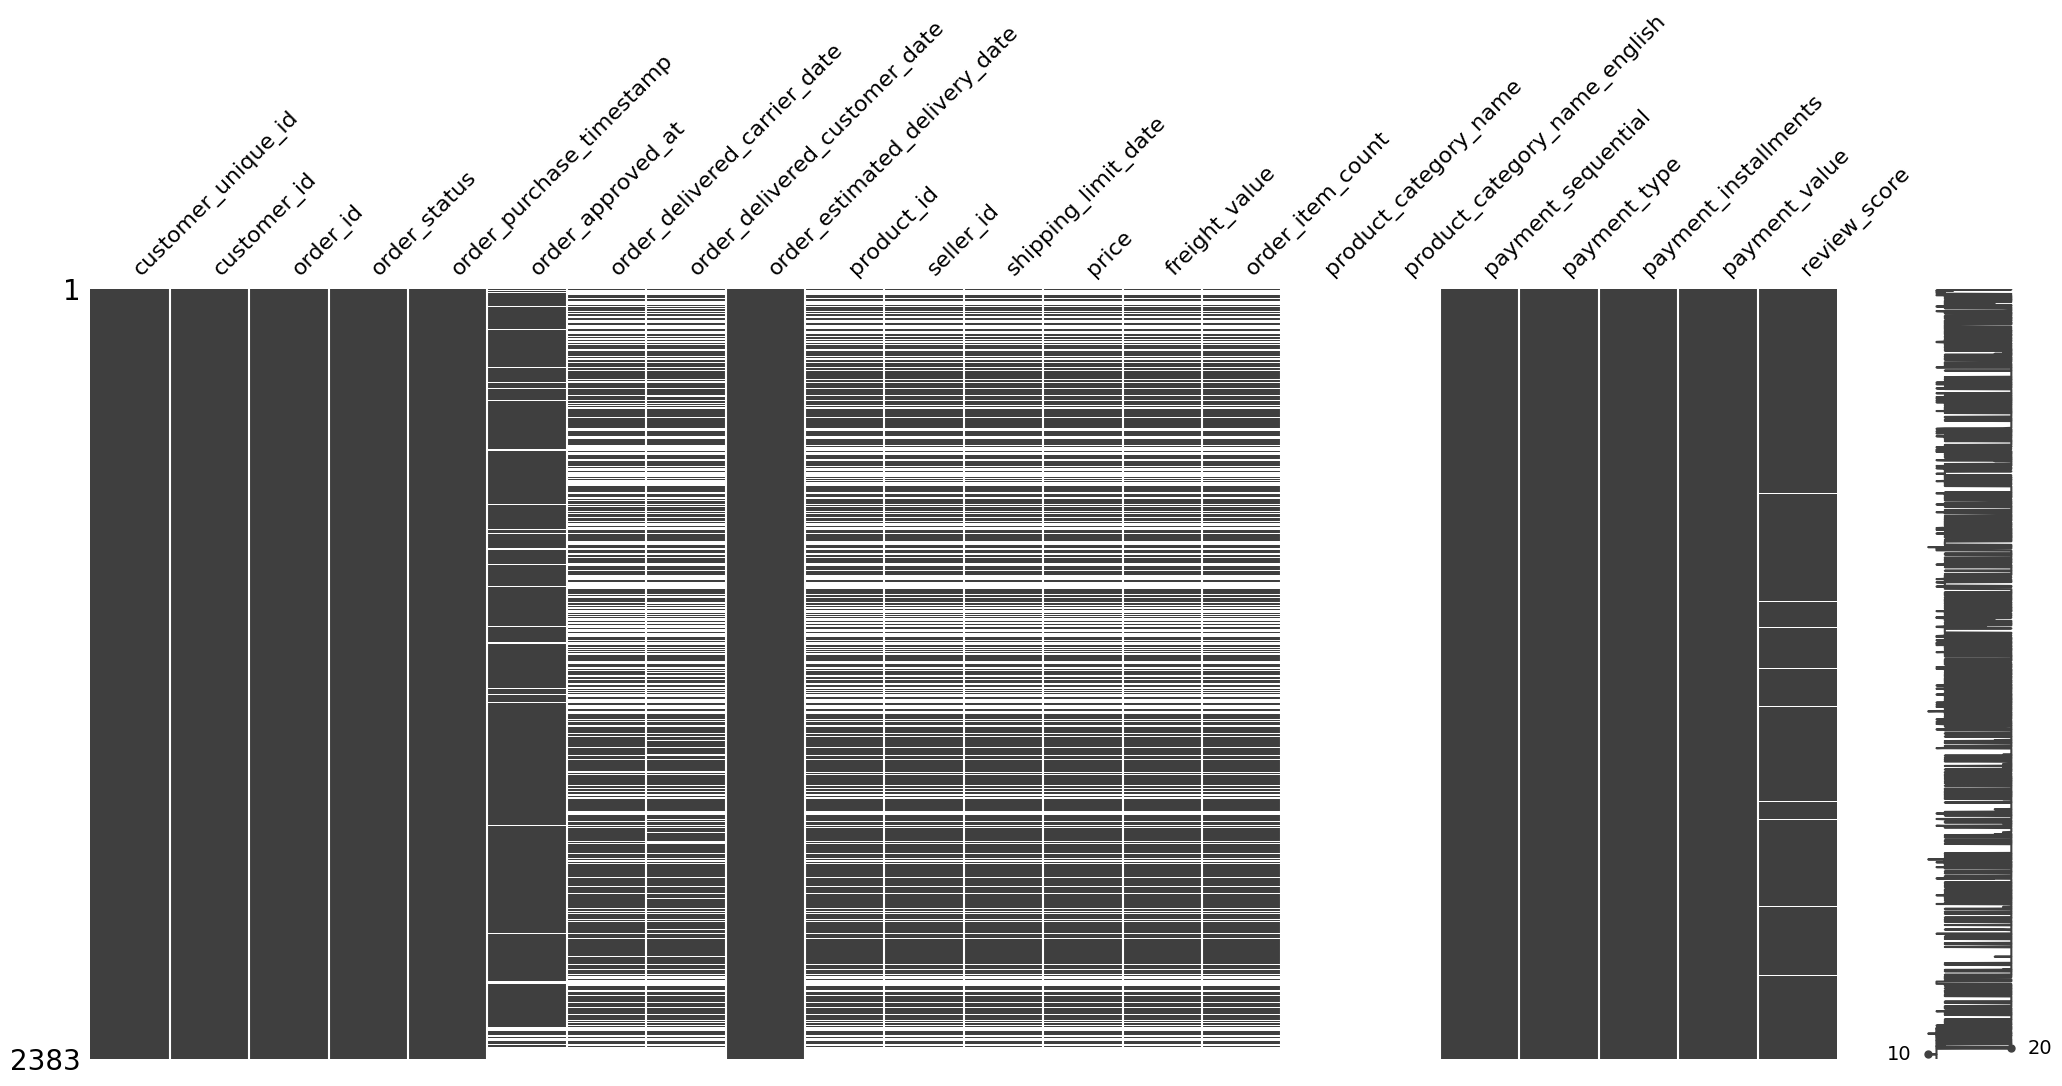

In [47]:
msno.matrix(master_data[master_data["product_category_name"].isna()])

In [48]:
master_data["product_category_name"].fillna("diversas", inplace=True)
master_data["product_category_name_english"].fillna("miscellaneous", inplace=True)

#### Order Reviews

In [49]:
master_data["review_score"] = master_data["review_score"].fillna("unknown").astype("str")

#### Order Items

In [50]:
master_data["order_item_count"].fillna(1, inplace=True)
master_data["product_id"].fillna("unknown", inplace=True)
master_data["seller_id"].fillna("unknown", inplace=True)
master_data["product_id"].fillna("unknown", inplace=True)
master_data["price"].fillna(-1, inplace=True)
master_data["freight_value"].fillna(-1, inplace=True)
master_data.drop(columns=["shipping_limit_date"], inplace=True)

#### Orders

In [51]:
master_data["order_status"].value_counts()

order_status
delivered      104684
shipped          1187
canceled          668
unavailable       650
invoiced          335
processing        324
created             5
approved            2
Name: count, dtype: int64

In [52]:
master_data[master_data["order_status"]=="created"]

,customer_unique_id,customer_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
36166,161e5b2b4513edb336986a8909218365,7d61b9f4f216052ba664f22e9c504ef1,90ab3e7d52544ec7bc3363c82689965f,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01,unknown,unknown,-1.0,-1.0,1.0,diversas,miscellaneous,1.0,credit_card,6.0,245.85,5.0
41304,355862aa14375fe3950ee04fef9c7a53,725e9c75605414b21fd8c8d5a1c2f1d6,7a4df5d8cff4090e541401a20a22bb80,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12,unknown,unknown,-1.0,-1.0,1.0,diversas,miscellaneous,1.0,boleto,1.0,37.84,1.0
44771,55fbb57fd54c35a38c80c2a032a6ca6e,438449d4af8980d107bf04571413a8e7,b5359909123fa03c50bdb0cfed07f098,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11,unknown,unknown,-1.0,-1.0,1.0,diversas,miscellaneous,1.0,credit_card,10.0,160.94,1.0
44772,10d5890ed5e7ec78a7db23b5ac579b17,4ee64f4bfc542546f422da0aeb462853,35de4050331c6c644cddc86f4f2d0d64,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08,unknown,unknown,-1.0,-1.0,1.0,diversas,miscellaneous,1.0,credit_card,7.0,105.87,unknown
59779,2e015e68fbfa36910263df5384e8e45c,964a6df3d9bdf60fe3e7b8bb69ed893a,dba5062fbda3af4fb6c33b1e040ca38f,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07,unknown,unknown,-1.0,-1.0,1.0,diversas,miscellaneous,1.0,boleto,1.0,137.60,unknown


In [53]:
master_data[master_data["order_status"]=="approved"]

,customer_unique_id,customer_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
1684,7b9d52d22310baecad0f9df64872208d,8886130db0ea6e9e70ba0b03d7c0d286,a2e4c44360b4a57bdff22f3a4630c173,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,19.85,10.96,2.0,informatica_acessorios,computers_accessories,1.0,credit_card,1.0,61.62,1.0
8189,6a068ccd3a149b5c8ceb4e04c83feb8a,b2191912d8ad6eac2e4dc3b6e1459515,132f1e724165a07f6362532bfb97486e,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,NaT,2017-05-22,c4a1c4638fa9e2e4861d141d6e0259e7,5444b12c82f21c923f2639ebc722c1ea,169.90,9.56,1.0,utilidades_domesticas,housewares,1.0,credit_card,5.0,179.46,4.0


In [54]:
master_data[master_data["order_status"]=="invoiced"]

,customer_unique_id,customer_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
24,2ad9e4ed11e15401527b7e30080ce45f,5c58d1ea5a893380ecdd96dd6dfd5ec5,dd359d3c294458c6d642b2eea9212bf5,invoiced,2016-10-04 13:02:10,2016-10-05 03:08:27,NaT,NaT,2016-11-24,f9bcf9d8e89d012d7dc24fe4de0abd80,897060da8b9a21f655304d50fd935913,164.00,13.20,1.0,informatica_acessorios,computers_accessories,1.0,boleto,1.0,177.20,2.0
37,d7afcd4b6f0d645a8efa24bef0b66ca0,81e4aed5ab4253757305267b80712689,711b9be9c346d9ecdb9d38a5e1e7e39b,invoiced,2016-10-04 13:38:37,2016-10-04 14:08:38,NaT,NaT,2016-11-24,d6f3bd7b1fc04fb1a2effb51ae44ab17,4b1eaadf791bdbbad8c4a35b65236d52,189.90,12.87,1.0,consoles_games,consoles_games,1.0,credit_card,10.0,202.77,1.0
56,45d9410bc1f3c6e36dea41d8f823ada6,442d66f0d96f656096dd70f1b0391e40,a6475bb7a50387e3c665534e15bd40ac,invoiced,2016-10-04 16:28:25,2016-10-05 02:46:17,NaT,NaT,2016-11-28,39731b928af43b0f49dd60d4706e403f,432c67955c0acd1fd6b0b5d678766a71,599.00,60.41,1.0,beleza_saude,health_beauty,1.0,boleto,1.0,659.41,1.0
112,8886115442775dd8a20c2dcc921c7cc8,0d00d77134cae4c58695086ad8d85100,e04f1da1f48bf2bbffcf57b9824f76e1,invoiced,2016-10-05 13:22:20,2016-10-06 15:51:38,NaT,NaT,2016-11-29,unknown,unknown,-1.00,-1.00,1.0,diversas,miscellaneous,1.0,credit_card,7.0,76.19,1.0
137,6a2da481aa7827b951175772a0fe8bb8,b2d7ae0415dbbca535b5f7b38056dd1f,2ce9683175cdab7d1c95bcbb3e36f478,invoiced,2016-10-05 21:03:33,2016-10-06 07:46:39,NaT,NaT,2016-11-25,unknown,unknown,-1.00,-1.00,1.0,diversas,miscellaneous,1.0,boleto,1.0,73.04,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103101,3fe6e0ec04e3f210fccc62a5fda8a6a0,ed3f4ba1e8981bd3773207b41a9de82b,b81dc96814c73196e795524a469a2c35,invoiced,2018-08-07 19:13:51,2018-08-07 19:25:15,NaT,NaT,2018-08-21,813abede22d2496612b447a3f55f629e,455f46ef09a9e45667e2981df84b5cc2,29.90,12.87,1.0,eletronicos,electronics,1.0,credit_card,3.0,42.77,1.0
103186,357ab7c8b61c05fbb41dd7aaf93ee4bd,d04b499809157673780addf5719f7af1,2da6df6ecc3f69f3642ce1fafad85d5a,invoiced,2018-08-07 22:22:53,2018-08-07 22:35:23,NaT,NaT,2018-08-15,f89caa3ea4fb5f7b6e7fb2bb4ba61881,d2374cbcbb3ca4ab1086534108cc3ab7,45.90,9.63,1.0,cama_mesa_banho,bed_bath_table,1.0,credit_card,1.0,55.53,4.0
103565,293d83a19659c4d3800744751f773288,d89f76444e908c953bd1f8390aec9a00,a03ac1d748cc1533566bf2c8199159d4,invoiced,2018-08-09 06:43:29,2018-08-09 06:55:06,NaT,NaT,2018-08-24,2b6f9eb2e0273b74678d183b325c122b,36a968b544695394e4e9d7572688598f,269.90,19.99,1.0,consoles_games,consoles_games,1.0,credit_card,2.0,289.89,1.0
103761,7575dad0caa94d97f8e293ad8f3c676f,d3ddbbd220a088a3e353cd270c184e60,67d06af97696c95df2bb26acf82db637,invoiced,2018-08-09 17:18:57,2018-08-09 17:50:12,NaT,NaT,2018-08-17,26e5b7d049012785d88313194cd576d2,7a241947449cc45dbfda4f9d0798d9d0,89.00,23.42,1.0,eletroportateis,small_appliances,1.0,credit_card,1.0,112.42,3.0


In [55]:
master_data[master_data["order_status"]=="invoiced"].isna().sum()

customer_unique_id                 0
customer_id                        0
order_id                           0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     335
order_delivered_customer_date    335
order_estimated_delivery_date      0
product_id                         0
seller_id                          0
price                              0
freight_value                      0
order_item_count                   0
product_category_name              0
product_category_name_english      0
payment_sequential                 0
payment_type                       0
payment_installments               0
payment_value                      0
review_score                       0
dtype: int64

In [56]:
master_data[master_data["order_status"]=="processing"].isna().sum()

customer_unique_id                 0
customer_id                        0
order_id                           0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     324
order_delivered_customer_date    324
order_estimated_delivery_date      0
product_id                         0
seller_id                          0
price                              0
freight_value                      0
order_item_count                   0
product_category_name              0
product_category_name_english      0
payment_sequential                 0
payment_type                       0
payment_installments               0
payment_value                      0
review_score                       0
dtype: int64

In [57]:
master_data[master_data["order_status"]=="shipped"].isna().sum()

customer_unique_id                  0
customer_id                         0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date    1187
order_estimated_delivery_date       0
product_id                          0
seller_id                           0
price                               0
freight_value                       0
order_item_count                    0
product_category_name               0
product_category_name_english       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
review_score                        0
dtype: int64

In [58]:
master_data[master_data["order_status"]=="canceled"].isna().sum()

customer_unique_id                 0
customer_id                        0
order_id                           0
order_status                       0
order_purchase_timestamp           0
order_approved_at                156
order_delivered_carrier_date     589
order_delivered_customer_date    661
order_estimated_delivery_date      0
product_id                         0
seller_id                          0
price                              0
freight_value                      0
order_item_count                   0
product_category_name              0
product_category_name_english      0
payment_sequential                 0
payment_type                       0
payment_installments               0
payment_value                      0
review_score                       0
dtype: int64

In [59]:
master_data[master_data["order_status"]=="unavailable"].isna().sum()

customer_unique_id                 0
customer_id                        0
order_id                           0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     650
order_delivered_customer_date    650
order_estimated_delivery_date      0
product_id                         0
seller_id                          0
price                              0
freight_value                      0
order_item_count                   0
product_category_name              0
product_category_name_english      0
payment_sequential                 0
payment_type                       0
payment_installments               0
payment_value                      0
review_score                       0
dtype: int64

In [60]:
# skimming function
def skim(data, name):
    summary = pd.DataFrame({
                'dataset' : name,
                'column': data.columns.values,
                'type': data.dtypes.values,
                'unique': data.nunique().values,
                'null': data.isna().sum().reset_index()[0],
                'null_pct': round(data.isna().sum().reset_index()[0]/len(data)*100, 2),
                'min': data.min().values,
                'max': data.max().values
                })
    return summary
print(master_data.shape)
skim(master_data, "master_data")

(107855, 21)


,dataset,column,type,unique,null,null_pct,min,max
0,master_data,customer_unique_id,object,96096,0,0.00,0000366f3b9a7992bf8c76cfdf3221e2,ffffd2657e2aad2907e67c3e9daecbeb
1,master_data,customer_id,object,99441,0,0.00,00012a2ce6f8dcda20d059ce98491703,ffffe8b65bbe3087b653a978c870db99
2,master_data,order_id,object,99441,0,0.00,00010242fe8c5a6d1ba2dd792cb16214,fffe41c64501cc87c801fd61db3f6244
3,master_data,order_status,object,8,0,0.00,approved,unavailable
4,master_data,order_purchase_timestamp,datetime64[ns],98875,0,0.00,2016-09-04 21:15:19,2018-10-17 17:30:18
5,master_data,order_approved_at,datetime64[ns],90733,175,0.16,2016-09-15 12:16:38,2018-09-03 17:40:06
6,master_data,order_delivered_carrier_date,datetime64[ns],81018,1907,1.77,2016-10-08 10:34:01,2018-09-11 19:48:28
7,master_data,order_delivered_customer_date,datetime64[ns],95664,3172,2.94,2016-10-11 13:46:32,2018-10-17 13:22:46
8,master_data,order_estimated_delivery_date,datetime64[ns],459,0,0.00,2016-09-30 00:00:00,2018-11-12 00:00:00
9,master_data,product_id,object,32952,0,0.00,00066f42aeeb9f3007548bb9d3f33c38,unknown


In [61]:
master_data.to_csv("../data/processed/master_data.csv", index=False)

### **Handling Outliers**

#### **Numerical, Continuous**

In [62]:
def distboxplot(data, bins, xticks, xlim, xlabel, unit, title=None, column=None, figsize=None):
    plt.style.use('default')
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=figsize,
        gridspec_kw={'height_ratios':[4,1]},
        sharex=True
    )

    if column:
        sns.histplot(data=data, x=column, bins=bins, kde=False, ax=axes[0])
        axes[1].boxplot(data=data, x=column, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data[column].mean()
        median = data[column].median()
        mad = abs(data[column] - data[column].median()).median()
    else:
        sns.histplot(data=data, bins=bins, kde=False, ax=axes[0])
        axes[1].boxplot(data, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data.mean()
        median = data.median()
        mad = abs(data - data.median()).median()
    
    # create tendencies measurement lines
    axes[0].axvline(x=mean, color="limegreen", linestyle="--", label=f"mean: {mean:.2f} {unit}")
    axes[0].axvline(x=median, color="orange", linestyle="-", label=f"median: {median:.2f} {unit}")

    axes[0].legend()
    axes[0].set_xlim(xlim[0], xlim[1])

    axes[1].set_xlabel(xlabel)
    axes[1].set_xticks(xticks)
    axes[1].set(yticklabels=[])

    if title:
        axes[0].set_title(title)
    plt.show();

**Payment Value**

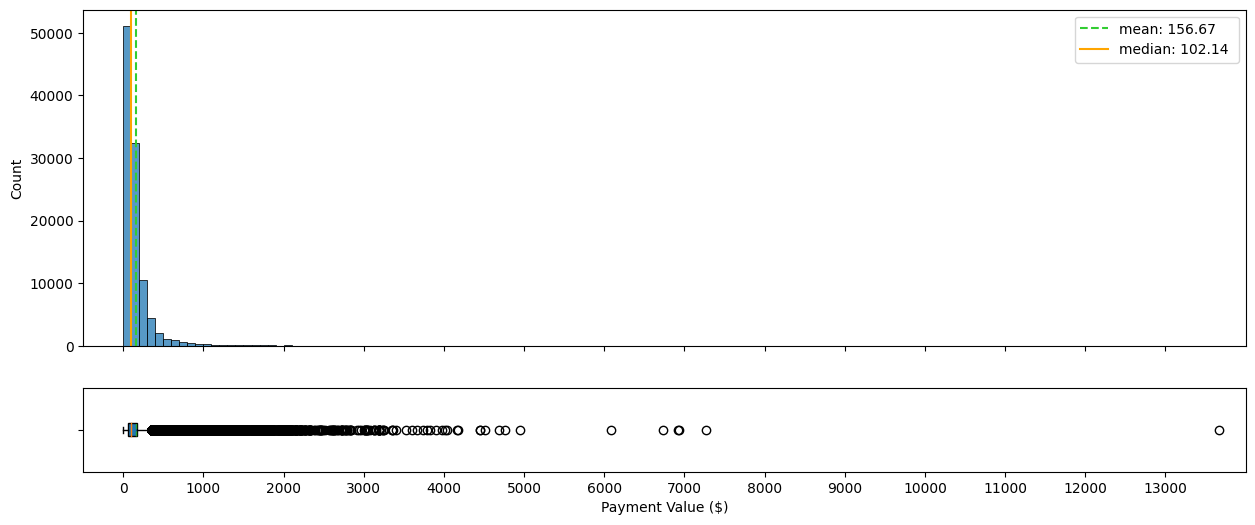

In [63]:
distboxplot(data=master_data[master_data["order_status"]=="delivered"], column="payment_value", bins=np.arange(0,14000,100),
            xticks=np.arange(0,14000,1000), xlim=[-500,14000], xlabel="Payment Value ($)", unit="",
            title=None, figsize=(15,6))

In [64]:
master_data[master_data["payment_value"]>10000]

,customer_unique_id,customer_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,price,freight_value,order_item_count,product_category_name,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_score
30164,0a0a92112bd4c708ca5fde585afaa872,1617b1357756262bfa56ab541c47bc16,03caa2c082116e1d31e67e9ae3700499,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,1680.0,28.01,8.0,telefonia_fixa,fixed_telephony,1.0,credit_card,1.0,13664.08,1.0


In [65]:
# clean_data["total_to_pay"] = (clean_data["price"] + clean_data["freight_value"]) * clean_data["order_item_id"]
# clean_data["overpaid"] = clean_data["total_to_pay"] - clean_data["payment_value"]
# distboxplot(data=clean_data, column="overpaid", bins=np.arange(-5000,14000,100),
#             xticks=np.arange(-5000,14000,1000), xlim=[-5000,14000], xlabel="Payment Value ($)", unit="",
#             title=None, figsize=(15,6))

In [66]:
# clean_data[clean_data["overpaid"]>1000]